# Stop words
Take the stop words out of the text and see if it improves the bias feature text (and the other one to a certain extent.

In [ ]:
import os
x = os.environ["VIRTUAL_ENV"] + "/.."
%cd {x}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression

from hyper.bias_scorer import BiasScorer
import hyper.eval as evl

Load the dataset and convert to lower

In [2]:
data = pd.read_csv(
    "../data/processed.csv",
    sep="\t",
    dtype={"content": "string", "label": bool}
)
data["content"] = data["content"].str.lower()

In [3]:
X = data["content"]
y = data["label"].astype(int)

In [4]:
stop_words = stopwords.words("english")
stop_punct = set(stop_words) | set(string.punctuation)

In [5]:
def rm_stop_punt(sentence, rm_list):
    return [word for word in word_tokenize(sentence) if not word in stop_punct]

In [6]:
data["trimmed"] = data["content"].apply(lambda x: rm_stop_punt(x, stop_punct))

In [7]:
data.head()

,label,content,trimmed
0,True,kucinich: reclaiming the money power from flic...,"[kucinich, reclaiming, money, power, flickr.co..."
1,True,trump just woke up & viciously attacked puerto...,"[trump, woke, viciously, attacked, puerto, ric..."
2,True,"liberals wailing about gun control, but what a...","[liberals, wailing, gun, control, abortion, ph..."
3,True,laremy tunsil joins nfl players in kneeling du...,"[laremy, tunsil, joins, nfl, players, kneeling..."
4,False,it's 1968 all over againalmost a half-century ...,"['s, 1968, againalmost, half-century, ago, 196..."


## Calculate bias scores

In [8]:
word_list = pd.read_csv("../data/bias/bias-lexicon.txt", header=None, names=["word"])

In [9]:
bs = BiasScorer(word_list["word"])

In [10]:
scores = [bs.score(word_list) for word_list in data["trimmed"]]

In [11]:
# add the scores to the dataset
data["lemma_score"] = [x for (x, _, _) in scores]
data["stem_score"] = [y for (_, y, _) in scores]

In [12]:
model = LogisticRegression(max_iter=300, class_weight="balanced")

In [13]:
evl.report_algorithm(data[["lemma_score"]], y, model)

{'acc': [0.5689922480620154, 0.022252248208383455],
 'prec': [0.43167777629386156, 0.02715268736963195],
 'rec': [0.5554078014184397, 0.10229205764422614],
 'f1': [0.48334290725795814, 0.05684506232083637]}

In [14]:
evl.report_algorithm(data[["stem_score"]], y, model)

{'acc': [0.5581395348837209, 0.029822300870808276],
 'prec': [0.4256575620507851, 0.02981869903519063],
 'rec': [0.5679964539007093, 0.10095863630793898],
 'f1': [0.48328761581098034, 0.05053470879129024]}

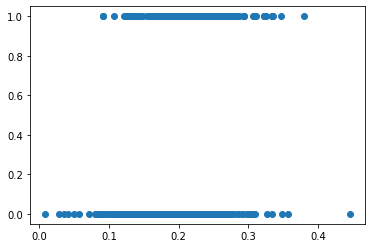

In [15]:
plt.scatter(data["lemma_score"], data["label"])

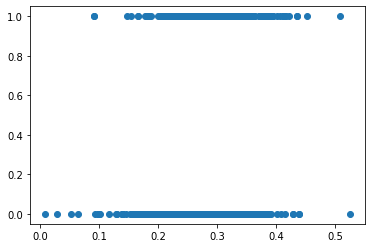

In [16]:
plt.scatter(data["stem_score"], data["label"])

## Combining with semantic features

In [17]:
with open("../data/transformed/spacy_flair.pickle", "rb") as file:
    X_transformed = pickle.load(file)

In [18]:
big_data = pd.concat([data, pd.DataFrame(X_transformed)], axis=1)
big_X = big_data.drop(["label", "content", "trimmed"], axis=1)

In [19]:
evl.report_algorithm(big_X, y, model)

{'acc': [0.8031007751937983, 0.03753090988189211],
 'prec': [0.7204008398488527, 0.054281538261511136],
 'rec': [0.7693262411347519, 0.059111066035563674],
 'f1': [0.7426885640272767, 0.04677458063181635]}

In [20]:
evl.report_algorithm(X_transformed, y, model)

{'acc': [0.8031007751937983, 0.03753090988189211],
 'prec': [0.7204008398488527, 0.054281538261511136],
 'rec': [0.7693262411347519, 0.059111066035563674],
 'f1': [0.7426885640272767, 0.04677458063181635]}

It doesn't make a difference